In [1]:
# Import necessary libraries
import pandas as pd

# Define the file path
file_path = '/content/drive/MyDrive/Colab Notebooks/Churn_Proj/WA_Fn-UseC_-Telco-Customer-Churn.csv'

# Load the dataset
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print("Dataset Overview:")
print(data.head())

# Display summary information about the dataset
print("\nDataset Info:")
print(data.info())

# Check for missing values
print("\nMissing Values per Column:")
print(data.isnull().sum())


Dataset Overview:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies   

In [2]:
# Reload the dataset from the original file
file_path = '/content/drive/MyDrive/Colab Notebooks/Churn_Proj/WA_Fn-UseC_-Telco-Customer-Churn.csv'
data = pd.read_csv(file_path)

# Drop the irrelevant 'customerID' column
if 'customerID' in data.columns:
    data = data.drop(columns=['customerID'])
else:
    print("Column 'customerID' not found. Skipping drop operation.")

# Convert 'TotalCharges' to numeric, handling non-numeric values
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# Fill any missing values in 'TotalCharges' with the median value
data['TotalCharges'] = data['TotalCharges'].fillna(data['TotalCharges'].median())

# Verify and re-encode the 'Churn' column
# Strip whitespace and map 'Yes' -> 1 and 'No' -> 0
print("Unique values in 'Churn' column before encoding:", data['Churn'].unique())
data['Churn'] = data['Churn'].str.strip()
data['Churn'] = data['Churn'].replace({'Yes': 1, 'No': 0})

# Verify encoding worked correctly
print("Class distribution in 'Churn' column after encoding:")
print(data['Churn'].value_counts())

# Identify categorical columns for encoding (now excluding 'Churn' automatically)
categorical_columns = data.select_dtypes(include=['object']).columns
print("Categorical Columns:", categorical_columns)

# One-hot encode categorical columns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Define preprocessing for categorical and numerical columns
numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

# Prepare features (X) and target (y)
X = data.drop(columns=['Churn'])
y = data['Churn']

# Apply preprocessing to the features
X = preprocessor.fit_transform(X)

print("Preprocessing complete. Data is ready for modeling!")

# Check the target column distribution
from collections import Counter
print("Class distribution in target column (y):")
print(Counter(y))


Unique values in 'Churn' column before encoding: ['No' 'Yes']
Class distribution in 'Churn' column after encoding:
Churn
0    5174
1    1869
Name: count, dtype: int64
Categorical Columns: Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')


<ipython-input-2-2832b3829506>:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Churn'] = data['Churn'].replace({'Yes': 1, 'No': 0})


Preprocessing complete. Data is ready for modeling!
Class distribution in target column (y):
Counter({0: 5174, 1: 1869})


In [3]:
# Feature Engineering Based on Significant Features
# -------------------------------------------------

# Interaction between tenure and MonthlyCharges
data['Tenure_Monthly_Interaction'] = data['tenure'] * data['MonthlyCharges']

# Ratio of MonthlyCharges to tenure (already exists, but keep it updated)
if 'MonthlyCharges_Per_Tenure' not in data.columns:
    data['MonthlyCharges_Per_Tenure'] = data['MonthlyCharges'] / (data['tenure'] + 1)

# Binary flag for high MonthlyCharges (already exists, ensure updated)
monthly_charges_median = data['MonthlyCharges'].median()
if 'HighMonthlyCharges' not in data.columns:
    data['HighMonthlyCharges'] = (data['MonthlyCharges'] > monthly_charges_median).astype(int)

# Combined effect of no TechSupport and high MonthlyCharges
if 'TechSupport' in data.columns:
    data['NoTechSupport_HighCharges'] = (data['TechSupport'] == 'No').astype(int) * data['HighMonthlyCharges']
else:
    print("TechSupport column not found. Skipping related feature.")

# Binary flag for customers using electronic payment
if 'IsElectronicPayment' in data.columns:
    data['UsesElectronicPayment'] = data['IsElectronicPayment']
else:
    # If 'IsElectronicPayment' doesn't exist, create it dynamically
    if 'PaymentMethod' in data.columns:
        data['UsesElectronicPayment'] = (data['PaymentMethod'] == 'Electronic check').astype(int)
        print("Created 'UsesElectronicPayment' from 'PaymentMethod' column.")
    else:
        print("Neither 'IsElectronicPayment' nor 'PaymentMethod' column found. Skipping related feature.")

# Combined effect of no OnlineSecurity and high MonthlyCharges
if 'OnlineSecurity' in data.columns:
    data['NoOnlineSecurity_HighCharges'] = (data['OnlineSecurity'] == 'No').astype(int) * data['HighMonthlyCharges']
else:
    print("OnlineSecurity column not found. Skipping related feature.")

# Combined effect of tenure and OnlineBackup
if 'OnlineBackup' in data.columns:
    data['Tenure_OnlineBackup_No'] = (data['OnlineBackup'] == 'No').astype(int) * data['tenure']
else:
    print("OnlineBackup column not found. Skipping related feature.")

# Aggregate feature: sum of tenure and MonthlyCharges (already exists, ensure updated)
if 'Tenure_Charges_Sum' not in data.columns:
    data['Tenure_Charges_Sum'] = data['tenure'] + data['MonthlyCharges']

# Check which engineered features exist in the dataset
engineered_features = [
    'Tenure_Monthly_Interaction', 'MonthlyCharges_Per_Tenure', 'HighMonthlyCharges',
    'NoTechSupport_HighCharges', 'UsesElectronicPayment', 'NoOnlineSecurity_HighCharges',
    'Tenure_OnlineBackup_No', 'Tenure_Charges_Sum'
]
available_features = [feature for feature in engineered_features if feature in data.columns]

# Print available engineered features
print("Newly Engineered Features:")
print(data[available_features].head())


Created 'UsesElectronicPayment' from 'PaymentMethod' column.
Newly Engineered Features:
   Tenure_Monthly_Interaction  MonthlyCharges_Per_Tenure  HighMonthlyCharges  \
0                       29.85                  14.925000                   0   
1                     1936.30                   1.627143                   0   
2                      107.70                  17.950000                   0   
3                     1903.50                   0.919565                   0   
4                      141.40                  23.566667                   1   

   NoTechSupport_HighCharges  UsesElectronicPayment  \
0                          0                      1   
1                          0                      0   
2                          0                      0   
3                          0                      0   
4                          1                      1   

   NoOnlineSecurity_HighCharges  Tenure_OnlineBackup_No  Tenure_Charges_Sum  
0                     

In [4]:
from sklearn.model_selection import train_test_split
from collections import Counter

# Perform a stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Check class distribution in training and testing sets
print("Class distribution in y_train:")
print(Counter(y_train))

print("Class distribution in y_test:")
print(Counter(y_test))


Class distribution in y_train:
Counter({0: 3622, 1: 1308})
Class distribution in y_test:
Counter({0: 1552, 1: 561})


In [5]:
import sys

# Add the directory containing the utility files to Python path
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Churn_Proj/')

from lasso_model import train_lasso_model, evaluate_model as evaluate_lasso
from gridsearch_model import train_gridsearch_model, evaluate_model as evaluate_gridsearch


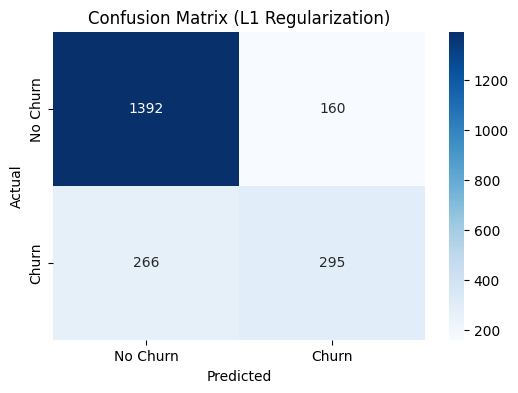

L1 Regularization Metrics:
Accuracy: 0.7983909133932797
AUC-ROC: 0.8433583484940368
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1552
           1       0.65      0.53      0.58       561

    accuracy                           0.80      2113
   macro avg       0.74      0.71      0.72      2113
weighted avg       0.79      0.80      0.79      2113



In [6]:
# Train the L1-regularized logistic regression model
lasso_model = train_lasso_model(X_train, y_train, C=0.1)
lasso_metrics = evaluate_lasso(lasso_model, X_test, y_test)

# Print metrics
print("L1 Regularization Metrics:")
print("Accuracy:", lasso_metrics['accuracy'])
print("AUC-ROC:", lasso_metrics['auc_roc'])
print("Classification Report:\n", lasso_metrics['classification_report'])


Fitting 5 folds for each of 3 candidates, totalling 15 fits


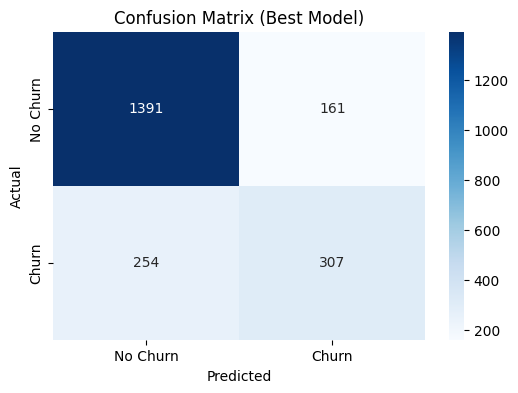

GridSearchCV Metrics:
Accuracy: 0.8035967818267865
AUC-ROC: 0.8438246549791426
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      1552
           1       0.66      0.55      0.60       561

    accuracy                           0.80      2113
   macro avg       0.75      0.72      0.73      2113
weighted avg       0.80      0.80      0.80      2113



In [7]:
# Define parameter grid for GridSearchCV
param_grid = {'C': [0.1, 1, 10], 'penalty': ['l1'], 'solver': ['liblinear']}

# Train the GridSearchCV model
best_model, grid_search = train_gridsearch_model(X_train, y_train, param_grid)

# Evaluate the GridSearchCV model
gridsearch_metrics = evaluate_gridsearch(best_model, X_test, y_test)

# Print metrics
print("GridSearchCV Metrics:")
print("Accuracy:", gridsearch_metrics['accuracy'])
print("AUC-ROC:", gridsearch_metrics['auc_roc'])
print("Classification Report:\n", gridsearch_metrics['classification_report'])


In [9]:
from sklearn.metrics import roc_curve, auc

# Calculate FPR and TPR for L1 Regularization Model
y_pred_prob_lasso = lasso_model.predict_proba(X_test)[:, 1]
fpr_lasso, tpr_lasso, _ = roc_curve(y_test, y_pred_prob_lasso)
roc_auc_lasso = auc(fpr_lasso, tpr_lasso)

# Calculate FPR and TPR for GridSearchCV Model
y_pred_prob_best = best_model.predict_proba(X_test)[:, 1]
fpr_best, tpr_best, _ = roc_curve(y_test, y_pred_prob_best)
roc_auc_best = auc(fpr_best, tpr_best)


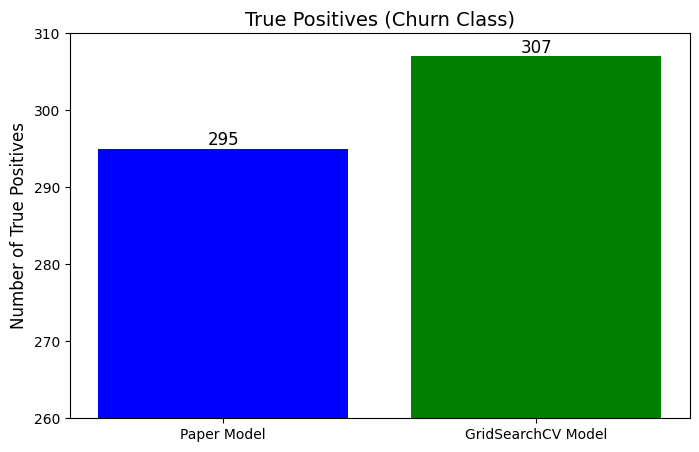

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# True positives for churners
true_positives = [295, 307]  # Paper Model, Best Model
labels = ['Paper Model', 'GridSearchCV Model']

# Bar chart
plt.figure(figsize=(8, 5))

# Exaggerate differences by setting the y-axis range close to the data
plt.bar(labels, true_positives, color=['blue', 'green'])
plt.ylim(260, 310)

# Add annotations to highlight values
for i, v in enumerate(true_positives):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=12, color='black')

# Title and labels
plt.title('True Positives (Churn Class)', fontsize=14)
plt.ylabel('Number of True Positives', fontsize=12)

plt.show()


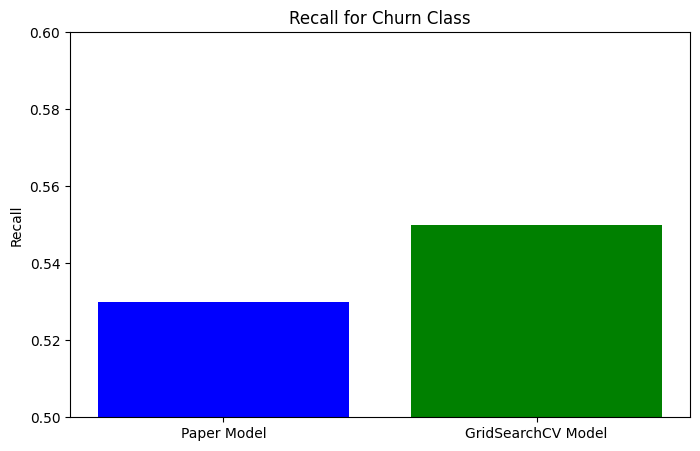

In [11]:
# Recall for churners
recall_churn = [0.53, 0.55]  # Paper Model, Best Model

# Bar chart
plt.figure(figsize=(8, 5))
plt.bar(labels, recall_churn, color=['blue', 'green'])
plt.title('Recall for Churn Class')
plt.ylabel('Recall')
plt.ylim(0.5, 0.6)
plt.show()


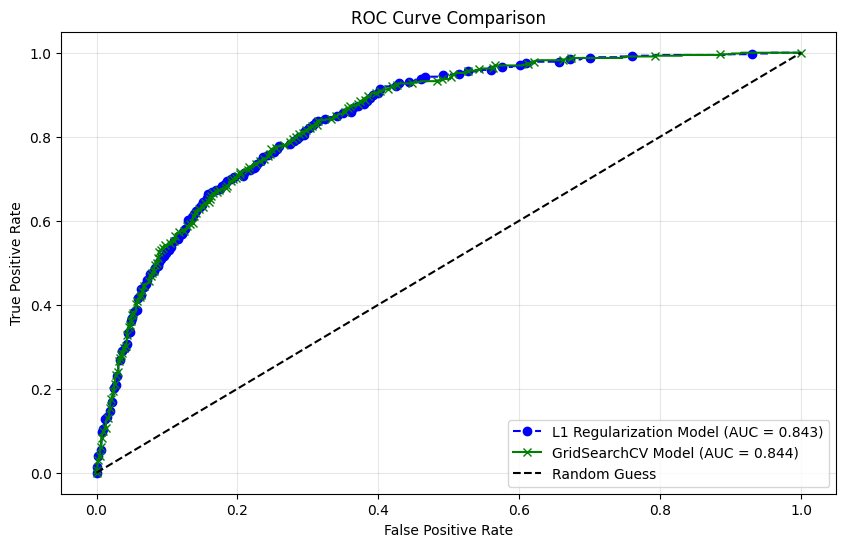

In [ ]:
import matplotlib.pyplot as plt

# Plot ROC Curves
plt.figure(figsize=(10, 6))

# L1 Regularization Model
plt.plot(fpr_lasso, tpr_lasso, label=f'L1 Regularization Model (AUC = {roc_auc_lasso:.3f})', linestyle='--', color='blue', marker='o', markevery=5)

# GridSearchCV Model
plt.plot(fpr_best, tpr_best, label=f'GridSearchCV Model (AUC = {roc_auc_best:.3f})', color='green', marker='x', markevery=5)

# Random Guess Line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Add Labels, Title, and Legend
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()
